In [10]:
import os
import re
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoConfig, AutoModelForCausalLM, PreTrainedModel

In [11]:
# os.chdir('..')
os.chdir(os.path.expanduser("~/clm"))

In [12]:
from args.model_args import ModelArguments, SoftMaxScaleType
from models.llama_nope import monkey_patch_before

monkey_patch_before(ModelArguments(use_flash_attention=True, softmax_scale_type=SoftMaxScaleType.HS))
# monkey_patch_before(ModelArguments(softmax_scale_type=SoftMaxScaleType.HS))

In [13]:
# path = "ckpts/selected/tnl_hs_50k_18k/relu1_i1.7_st200_1e-1_sd598765/Feb14_21-10-16"
path = "ckpts/selected/tnl_hs_50k_8k/relu1_i1.6_st200_1e-1_sd31415/Feb13_17-23-43"
# path = "ckpts/selected/tnl_hs_50k_4k/relu1_i1.1_st200_1e-1_sd1001/Feb13_15-57-14"
config = AutoConfig.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path, use_flash_attention_2=True)
print(model)

OSError: Can't load the configuration of 'ckpts/selected/tnl_hs_50k_8k/relu1_i1.6_st200_1e-1_sd31415/Feb13_17-23-43'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'ckpts/selected/tnl_hs_50k_8k/relu1_i1.6_st200_1e-1_sd31415/Feb13_17-23-43' is the correct path to a directory containing a config.json file

In [ ]:
path = "ckpts_arxiv/llama_eval_entropy/runs/NoPE50k_HS8k(8k)|Feb15_11-17-45"
entropy = np.load(os.path.join(path, "entropy.npy"))  # [n_layers, n_heads, seq_len]
# entropy = entropy[:, :, :2048]
# entropy_mean = entropy.mean(axis=2)  # [n_layers, n_heads]
# path = "ckpts_arxiv/llama_eval_entropy/runs/NoPE50k(4k)|Feb14_22-57-11"
# entropy2 = np.load(os.path.join(path, "entropy.npy"))  # [n_layers, n_heads, seq_len]
# entropy2 = entropy2[:, :, :2048]

In [ ]:
data = []
for i in range(config.num_hidden_layers):
    # qsk = model.model.layers[i].self_attn.qsk.detach().tolist()
    # qsc = model.model.layers[i].self_attn.qsc.detach().tolist()
    # scale = sorted(model.model.layers[i].self_attn.scale_param.detach().tolist())
    scale = model.model.layers[i].self_attn.scale_param.detach().tolist()
    for j in range(config.num_attention_heads):
        # query = model.model.layers[i].self_attn.q_proj.weight[:, j * 64 : (j + 1) * 64].detach()
        # key = model.model.layers[i].self_attn.k_proj.weight[:, j * 64 : (j + 1) * 64].detach()
        # value = model.model.layers[i].self_attn.v_proj.weight[:, j * 64 : (j + 1) * 64].detach()
        # scale1 = 8 * model.model.layers[i].self_attn.scale_param[j, 1].item()
        # scale2 = 8 * model2.model.layers[i].self_attn.scale_param[j].item()
        data.append(
            {
                "layer": i,
                "head": j,
                # "value": int(scale1<1.3) * 2 + int(scale2<1.1),
                "scale": scale[j],
                # "entropy": entropy_mean[i, j],
                "entropy": entropy[i, j, -1],
                # "entropy2k": entropy2[i, j, -1],
            }
        )
df = pd.DataFrame(data)
# for each layer, average over all heads
# df = df.groupby("layer").mean().reset_index()
print(df)

     layer  head     scale    entropy
0        0     0  1.429688  12.625000
1        0     1  1.546875  12.242188
2        0     2  1.398438  12.835938
3        0     3  1.429688  12.851562
4        0     4  1.492188  12.664062
..     ...   ...       ...        ...
699     21    27  1.000000   8.179688
700     21    28  1.000000   7.707031
701     21    29  1.070312   8.601562
702     21    30  1.085938   7.066406
703     21    31  1.101562   7.804688

[704 rows x 4 columns]


In [ ]:
plot_df = df
# lim = (15, 22)
# plot_df = plot_df[plot_df["layer"]< lim[1]]
# plot_df = plot_df[plot_df["layer"] >= lim[0]]
plot_df = plot_df[plot_df["layer"].isin([i for i in range(2, 22, 3)])]

Text(0.5, 1.0, 'HS8k ent vs scale')

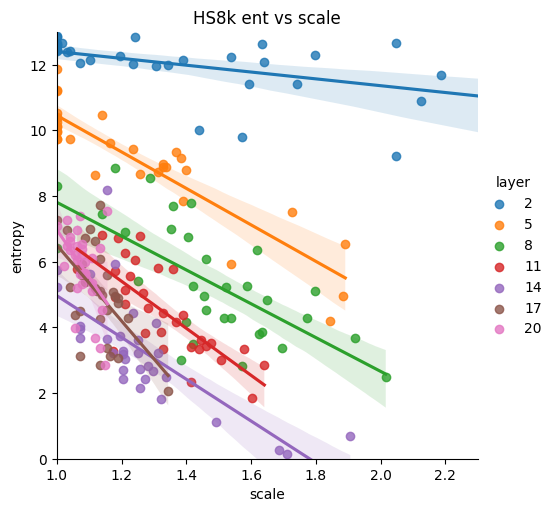

In [ ]:
# sns.heatmap(df.pivot(index="layer", columns="head", values="value"), annot=True, fmt="d", cmap="YlGnBu")
# sns.scatterplot(df, x="scale", y="entropy", hue="layer", palette="Spectral")
# sns.scatterplot(plot_df, x="scale", y="entropy", hue="layer", palette="tab10")
sns.lmplot(plot_df, x="scale", y="entropy", hue="layer", palette="tab10")
# sns.scatterplot(df, x="entropy2k", y="entropy", hue="layer", palette="Spectral")
# sns.scatterplot(df, x="scale", y="query", hue="entropy", style="head")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.xlim(1, 2.3)
plt.ylim(0, 13)
plt.title("HS8k ent vs scale")